In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from pprint import pprint
from scipy.stats import linregress
from datetime import datetime

%matplotlib inline

# Impor the OpenWeatherMap API key
from config import api_key


In [4]:
#Variables used in API call, oldest date is furthest back we are willing to go
oldest_date = "2014-01-31"
company_symbols = ["TAN",
                    "ENPH",
                    "SEDG",
                    "FSLR",
                    "HYDR",
                    "PLUG",
                    "BLDP",
                    "BE",
                    "FAN",
                    "TAC",
                    "TPIC",
                    "AMSC"]
time_function = "TIME_SERIES_MONTHLY"
base_url = "https://www.alphavantage.co/query?"

company_data = []

for symbol in company_symbols:
    finished_url = f"{base_url}function={time_function}&symbol={symbol}&apikey={api_key}"
    print(f"Processing {symbol}")

    result_data = requests.get(finished_url).json()
    print(result_data)

    time.sleep(1)

    for monthly in result_data["Monthly Time Series"]:
        monthly_date = time.strptime(monthly, "%Y-%m-%d")
        oldest = time.strptime(oldest_date, "%Y-%m-%d")
        if (monthly_date < oldest):
            continue
        stock_date = monthly
        stock_close = result_data["Monthly Time Series"][monthly]["4. close"]
        company_data.append({"Symbol":symbol,
                            "Date":stock_date,
                            "Closing Price":stock_close})

company_data_df = pd.DataFrame(company_data)
company_data_df


Processing TAN
{'Information': 'Thank you for using Alpha Vantage! Our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.'}


KeyError: 'Monthly Time Series'

In [6]:
#Read data from the saved CSV file and sort it by symbol and date
read_data_df = pd.read_csv("data/company_data.csv", index_col="Stock_ID")
ordered_data_df = read_data_df.sort_values(by=["Symbol", "Date"])
ordered_data_df

,Symbol,Date,Closing Price,Type
Stock_ID,,,,
1355,AMSC,2014-01-31,1.50,Wind
1354,AMSC,2014-02-28,1.85,Wind
1353,AMSC,2014-03-31,1.61,Wind
1352,AMSC,2014-04-30,1.28,Wind
1351,AMSC,2014-05-30,1.40,Wind
...,...,...,...,...
1133,TPIC,2024-05-31,5.48,Wind
1132,TPIC,2024-06-28,3.99,Wind
1131,TPIC,2024-07-31,4.26,Wind


In [13]:
# Ensure the 'Date' column is in datetime format
read_data_df['Date'] = pd.to_datetime(read_data_df['Date'])
# Sort the data by Symbol and Date
ordered_data_df = read_data_df.sort_values(by=["Symbol", "Date"])

# Calculate daily returns
ordered_data_df['Return'] = ordered_data_df.groupby('Symbol')['Closing Price'].pct_change()

# Calculate volatility (standard deviation of returns) for each sector/type
volatility_df = ordered_data_df.groupby('Type')['Return'].std().reset_index()
print(volatility_df)

# Rename the columns for clarity
volatility_df.columns = ['Type', 'Volatility']



       Type    Return
0  Hydrogen  0.277191
1     Solar  0.181030
2      Wind  0.342261


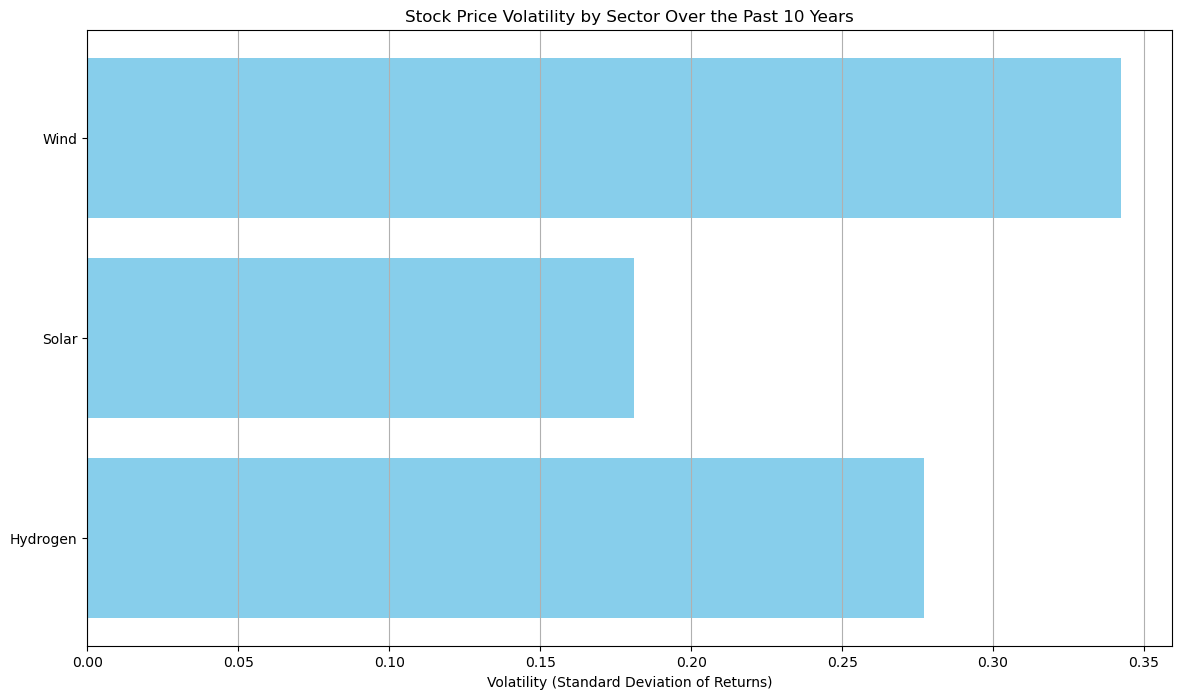

In [15]:
# Plotting
plt.figure(figsize=(14, 8))
plt.barh(volatility_df['Type'], volatility_df['Volatility'], color='skyblue')
plt.xlabel('Volatility (Standard Deviation of Returns)')
plt.title('Stock Price Volatility by Sector/Type Over the Past 10 Years')
plt.grid(axis='x')
plt.show()
